In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(rc={'figure.figsize': (12, 8)})
sns.set_style('whitegrid')

In [3]:
import numpy as np
import tensorflow as tf

import sklearn
import sklearn.decomposition
import scipy

In [4]:
import pathlib
import plot_export

export_path = pathlib.Path('export', '10_polynomial_interpolation')
export_path

PosixPath('export/10_polynomial_interpolation')

In [5]:
XY_true = np.array([
    [-2., -3.],
    [-1., 0.5],
    [0., -0.5],
    [1., 2.],
    [2., 5.],
])
true_function = scipy.interpolate.lagrange(*XY_true.T)

plot_export.to_text(
    export_path / 'true_observations.dat',
    XY_true.T,
    ['X', 'Y'],
)

# def true_function(x):
    # return 0.2 * x ** 3 + x ** 2 - 0.5 * x
    # return 0.1 * (x + 1.25) ** 2 * (x + .5) * (x - .5) ** 2

def noise(x):
    return np.random.RandomState(42).normal(scale=1., size=x.shape)

In [6]:
X = np.array([
    -2.,
    -1.8,
    -1.3,
    -1.,
    -0.8,
    -0.1,
    0.3,
    1.,
    1.2,
    1.8,
    2.,
])[..., None]
Y = true_function(X)
E = noise(X)

plot_export.to_text(
    export_path / 'training_data.dat',
    [X, Y, E, Y + E],
    ['X', 'Ytrue', 'noise', 'Y'],
)

Xt = np.mgrid[-2.5:2.5:100j][..., None]
Yt = true_function(Xt)


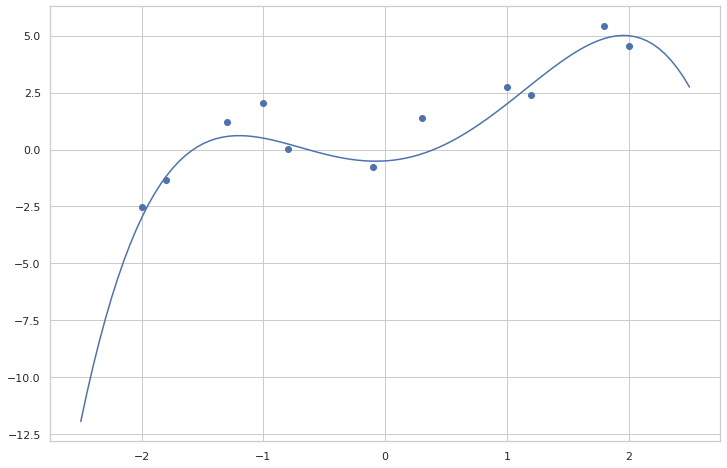

In [7]:
plt.plot(Xt, Yt)
plt.scatter(X, Y + E)

In [8]:
lagrange = scipy.interpolate.lagrange(X[..., 0], Y[..., 0] + E[..., 0])
Yt_lagrange = lagrange(Xt[..., 0])[..., None]

lagrange.coefficients

array([ -0.58545902,   0.15246393,   5.47373838,  -1.87008271,
       -17.0789586 ,   7.86473132,  19.4880671 , -12.54876589,
        -4.86796929,   6.77385579,  -0.03418627])

In [9]:
interpolation = scipy.interpolate.interp1d(
    X[..., 0],
    Y[..., 0] + E[..., 0],
    kind='slinear',
    fill_value='extrapolate',
)
Yt_interpolate = interpolation(Xt[..., 0])[..., None]

In [10]:
PCA = sklearn.decomposition.PCA(n_components=2).fit(np.concatenate([X, Y], axis=-1))

first_component = PCA.components_[..., 0] 
scale = first_component[1] / first_component[0]
shift = PCA.mean_[1] - scale * PCA.mean_[0]

Yt_PCA = scale * Xt + shift

In [11]:
LS = sklearn.linear_model.LinearRegression().fit(X, Y)
Yt_LS = LS.predict(Xt)

In [12]:
LAE = sklearn.linear_model.SGDRegressor(loss='epsilon_insensitive', epsilon=0.).fit(X, Y)
Yt_LAE = LAE.predict(Xt)

In [13]:
Ridge = sklearn.linear_model.Ridge().fit(X, Y)
Yt_Ridge = Ridge.predict(Xt)

In [14]:
LS_dual = sklearn.linear_model.LinearRegression().fit(Y, X)
Yt_LS_dual = 1. / LS_dual.coef_ * Xt - LS_dual.intercept_ / LS_dual.coef_

In [15]:
quad = sklearn.preprocessing.PolynomialFeatures(2).fit(X)
Quad_LS = sklearn.linear_model.LinearRegression().fit(quad.transform(X), Y)

Yt_Quad_LS = Quad_LS.predict(quad.transform(Xt))

In [16]:
cube = sklearn.preprocessing.PolynomialFeatures(3).fit(X)
Cube_LS = sklearn.linear_model.LinearRegression().fit(cube.transform(X), Y)

Yt_Cube_LS = Cube_LS.predict(cube.transform(Xt))

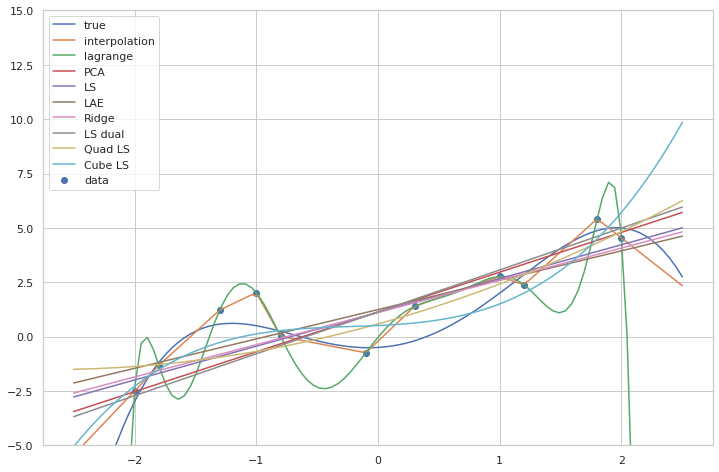

In [17]:
plt.plot(
    Xt,
    Yt,
    label='true'
)

plt.plot(
    Xt,
    Yt_interpolate,
    label='interpolation'
)

plt.plot(
    Xt,
    Yt_lagrange,
    label='lagrange'
)

plt.plot(
    Xt,
    Yt_PCA,
    label='PCA'
)

plt.plot(
    Xt,
    Yt_LS,
    label='LS'
)

plt.plot(
    Xt,
    Yt_LAE,
    label='LAE'
)

plt.plot(
    Xt,
    Yt_Ridge,
    label='Ridge'
)

plt.plot(
    Xt,
    Yt_LS_dual,
    label='LS dual'
)

plt.plot(
    Xt,
    Yt_Quad_LS,
    label='Quad LS'
)

plt.plot(
    Xt,
    Yt_Cube_LS,
    label='Cube LS'
)

plt.scatter(
    X,
    Y + E,
    label='data'
)

plt.ylim(-5., 15.)
plt.legend()

In [18]:
plot_export.to_text(
    export_path / 'test_data.dat',
    [Xt, Yt, Yt_interpolate, Yt_lagrange, Yt_PCA, Yt_LS, Yt_LAE, Yt_Ridge, Yt_LS_dual, Yt_Quad_LS, Yt_Cube_LS],
    ['X', 'true', 'interpolate', 'lagrange', 'PCA', 'LS', 'LAE', 'Ridge', 'LSdual', 'QuadLS', 'CubeLS'],
)

In [19]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

In [77]:
def linear_model(x, w, b):
    return w * x + b


def log_joint_likelihood_broad(w, b, sigma):
    Y_preds = linear_model(tf.cast(X, tf.float32), w, b)
    data_likelihood = tfp.distributions.Normal(
        loc=tf.cast(Y + E, tf.float32),
        scale=1e-6 + tf.maximum(sigma, 0.),
    ).log_prob(Y_preds)
    
    w_prior = tfp.distributions.Normal(loc=0., scale=5.).log_prob(w)
    b_prior = tfp.distributions.Normal(loc=0., scale=5.).log_prob(b)
    sigma_prior = tfp.distributions.LogNormal(loc=float(np.log(0.5)), scale=.25).log_prob(sigma)

    
    return tf.reduce_mean(data_likelihood) + w_prior + b_prior + sigma_prior

In [78]:
def log_joint_likelihood_narrow(w, b, sigma):
    Y_preds = linear_model(tf.cast(X, tf.float32), w, b)
    data_likelihood = tfp.distributions.Normal(
        loc=tf.cast(Y + E, tf.float32),
        scale=1e-6 + tf.maximum(sigma, 0.),
    ).log_prob(Y_preds)
    
    w_prior = tfp.distributions.Normal(loc=1., scale=1.).log_prob(w)
    b_prior = tfp.distributions.Normal(loc=1., scale=1.).log_prob(b)
    # sigma_prior = tfp.distributions.LogNormal(loc=0., scale=.25).log_prob(sigma)
    sigma_prior = tfp.distributions.LogNormal(loc=float(np.log(0.5)), scale=.25).log_prob(sigma)

    
    return tf.reduce_mean(data_likelihood) + w_prior + b_prior + sigma_prior

In [79]:
def run_mcmc(log_joint_likelihood):
    initial_state = [1., 0., 1.]
    num_results = int(500)
    num_burnin_steps = int(500)
    step_size = [1., 1., 1.]

    adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
        tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=log_joint_likelihood,
            num_leapfrog_steps=3,
            step_size=step_size),
        num_adaptation_steps=int(num_burnin_steps * 0.8),
    )

    @tf.function
    def run_chain():
        samples, is_accepted = tfp.mcmc.sample_chain(
            num_results=num_results,
            num_burnin_steps=num_burnin_steps,
            current_state=initial_state,
            kernel=adaptive_hmc,
            trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
        )
        
        return samples, is_accepted

    samples, is_accepted = run_chain()
    return samples, is_accepted

In [80]:
samples_narrow, _ = run_mcmc(log_joint_likelihood_narrow)
samples_broad, _ = run_mcmc(log_joint_likelihood_broad)

In [81]:
def plot_samples(samples):
    ws, bs, sigams = samples

    ixs = np.random.choice(len(ws), size=[20])
    for ix in ixs:
        plt.plot(
            Xt,
            linear_model(Xt, ws[ix], bs[ix]),
            c='blue',
            alpha=.25,
        )

    Yts = linear_model(Xt, ws[:, None, None], bs[:, None, None])
    Yt_mean = tf.reduce_mean(Yts, axis=0)
    Yt_std = tf.math.reduce_std(Yts, axis=0)
    plt.plot(
        Xt,
        tf.reduce_mean(Yts, axis=0),
        c='red'
    )

    plt.fill_between(
        Xt[..., 0],
        Yt_mean[..., 0] - Yt_std[..., 0],
        Yt_mean[..., 0] + Yt_std[..., 0],
        facecolor='red',
        alpha=.3,
    )

    plt.scatter(
        X,
        Y + E,
        label='data'
    )

    plt.ylim(-5., 15.)
    plt.legend()

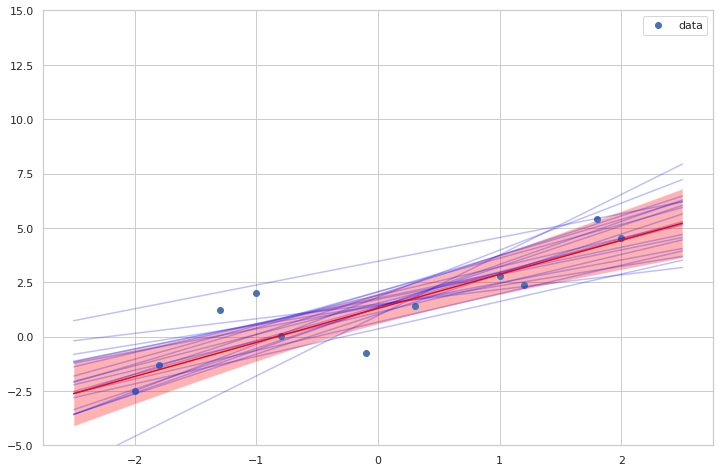

In [82]:
plot_samples(samples_broad)

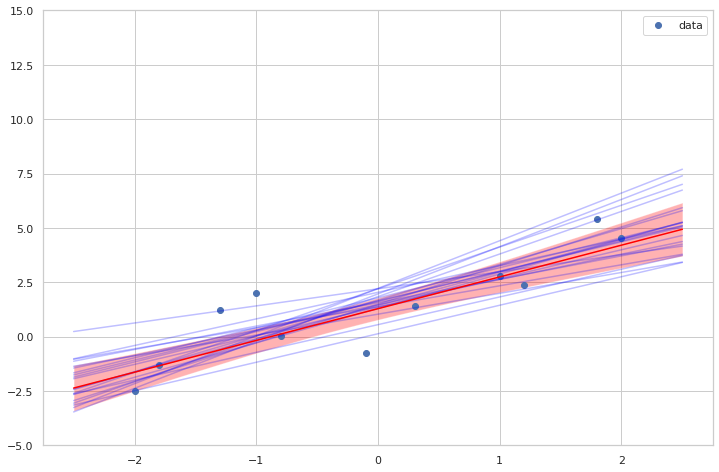

In [83]:
plot_samples(samples_narrow)

In [84]:
def export_samples(samples, name):
    ws, bs, sigams = samples

    ixs = np.random.choice(len(ws), size=[30])

    Yts = linear_model(Xt, ws[:, None, None], bs[:, None, None])
    Yt_mean = tf.reduce_mean(Yts, axis=0)
    Yt_std = tf.math.reduce_std(Yts, axis=0)

    plot_export.to_text(
        export_path / f'bayes_{name}.dat',
        [Xt, Yt, Yt_mean, Yt_std, 2 * Yt_std, *[Yts[ix] for ix in ixs]],
        ['X', 'true', 'mean', 'std', '2std', *[f'sample_{ix}' for ix in range(len(ixs))]],
    )

In [85]:
export_samples(samples_broad, 'broad')
export_samples(samples_narrow, 'narrow')

In [86]:
def log_marginal_likelihood(w, b, sigma):
    Y_preds = linear_model(tf.cast(X, tf.float32), w, b)
    data_likelihood = tfp.distributions.Normal(
        loc=tf.cast(Y + E, tf.float32),
        scale=1e-6 + tf.maximum(sigma, 0.),
    ).log_prob(Y_preds)
    return data_likelihood

In [89]:
(
    tf.reduce_mean(
        log_marginal_likelihood(
            samples_broad[0][:, None, None],
            samples_broad[1][:, None, None],
            samples_broad[2][:, None, None],
        )
    ),
    tf.reduce_mean(
        log_joint_likelihood_broad(
            samples_broad[0][:, None, None],
            samples_broad[1][:, None, None],
            samples_broad[2][:, None, None],
        )
    ),
    tf.reduce_mean(
        log_joint_likelihood_narrow(
            samples_broad[0][:, None, None],
            samples_broad[1][:, None, None],
            samples_broad[2][:, None, None],
        )
    )
)

(<tf.Tensor: shape=(), dtype=float32, numpy=-3.4448447>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-8.68491>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-5.973335>)

In [90]:
(
    tf.reduce_mean(
        log_marginal_likelihood(
            samples_narrow[0][:, None, None],
            samples_narrow[1][:, None, None],
            samples_narrow[2][:, None, None],
        )
    ),
    tf.reduce_mean(
        log_joint_likelihood_broad(
            samples_narrow[0][:, None, None],
            samples_narrow[1][:, None, None],
            samples_narrow[2][:, None, None],
        )
    ),
    tf.reduce_mean(
        log_joint_likelihood_narrow(
            samples_narrow[0][:, None, None],
            samples_narrow[1][:, None, None],
            samples_narrow[2][:, None, None],
        )
    )
)

(<tf.Tensor: shape=(), dtype=float32, numpy=-3.0250366>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-7.963104>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-5.016743>)